# ⚡ Daily Energy Price Preprocessing (14:00 data point)
This notebook preprocesses a univariate daily time series (`MarginalES`), one data point per day at 14:00h. We clean, enrich, and prepare the data for downstream use (anomaly detection, forecasting, or exploratory analysis).

In [1]:
# 📦 Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


## 1. Load & Inspect Data

In [2]:
# 🔄 Load data
df = pd.read_csv('../../data/hour_14_metrics.csv', parse_dates=["Datetime"])
df = df.set_index("Datetime").sort_index()

duplicates = df.index[df.index.duplicated()]
print(f"Found {len(duplicates)} duplicated datetime entries")
print(df.loc[duplicates])

# drop duplicates
df = df[~df.index.duplicated(keep='first')]

# # aggregate duplicates
# df = df.groupby(df.index).mean()


# 🌄 Daily frequency
df = df.asfreq("D")  # Forces gaps to appear if any dates are missing

df.head()


Found 0 duplicated datetime entries
Empty DataFrame
Columns: [MarginalES]
Index: []


,MarginalES
Datetime,
2018-01-01 14:00:00,2.30
2018-01-02 14:00:00,48.02
2018-01-03 14:00:00,52.00
2018-01-04 14:00:00,48.19
2018-01-05 14:00:00,52.02


## 2. Visualize Raw Series

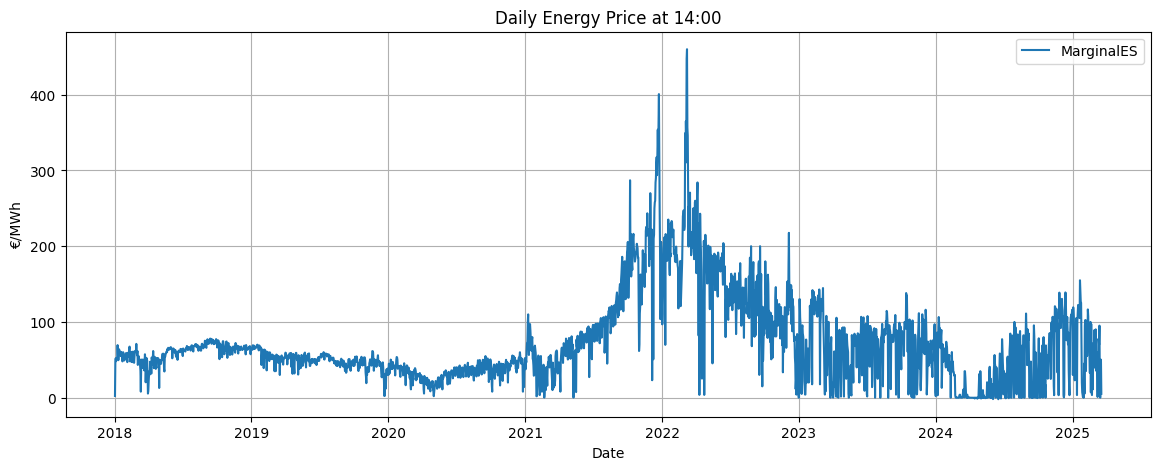

In [3]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['MarginalES'], label='MarginalES')
plt.title("Daily Energy Price at 14:00")
plt.xlabel("Date")
plt.ylabel("€/MWh")
plt.grid(True)
plt.legend()


## 3. Check Missing & Interpolate

In [4]:
# Check missing
missing_count = df['MarginalES'].isna().sum()
print(f"Missing days: {missing_count}")

# Interpolate linearly
df['MarginalES'] = df['MarginalES'].interpolate(method='time')


Missing days: 0


## 4. Feature Engineering

In [5]:
# Lag & rolling features
df['lag_1'] = df['MarginalES'].shift(1)
df['lag_7'] = df['MarginalES'].shift(7)
df['rolling_mean_7'] = df['MarginalES'].rolling(window=7).mean()
df['rolling_std_7'] = df['MarginalES'].rolling(window=7).std()

# Date-based features
df['dayofweek'] = df.index.dayofweek  # 0 = Monday
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear


## 5. Decomposition

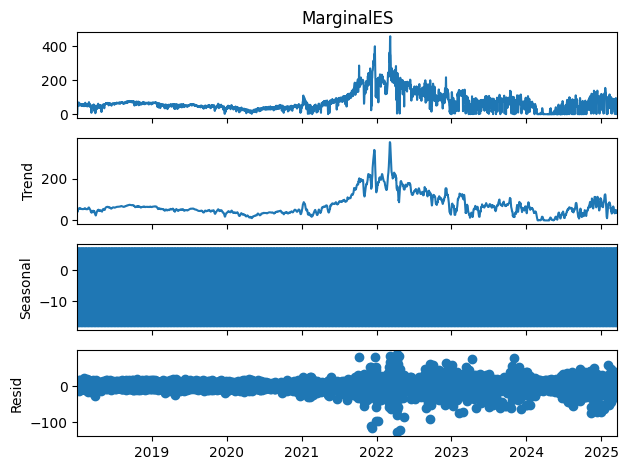

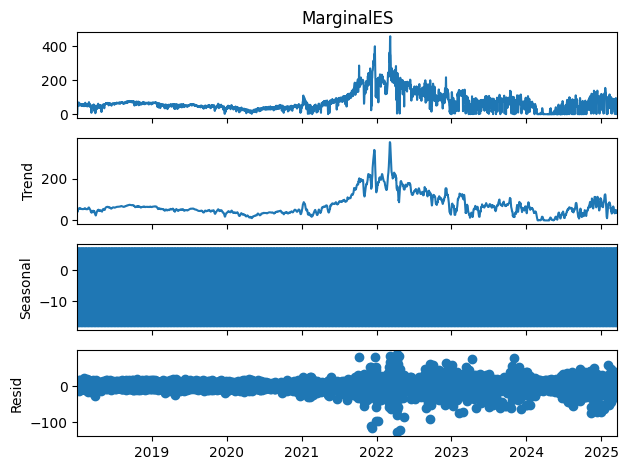

In [6]:
result = seasonal_decompose(df['MarginalES'], model='additive', period=7)
result.plot()


## 6. Stationarity Check

In [7]:
adf_result = adfuller(df['MarginalES'].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -2.4091962094953585
p-value: 0.13915765168483168


## 7. Outlier Detection

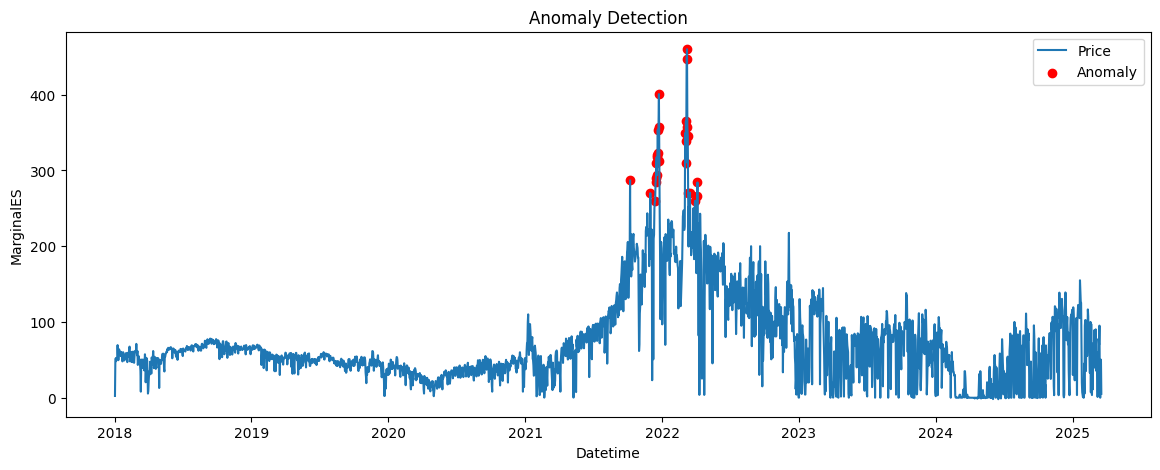

In [8]:
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[['MarginalES']])

# Plot anomalies
plt.figure(figsize=(14,5))
sns.lineplot(data=df, x=df.index, y='MarginalES', label='Price')
plt.scatter(df[df['anomaly'] == -1].index, 
            df[df['anomaly'] == -1]['MarginalES'], 
            color='red', label='Anomaly')
plt.title("Anomaly Detection")
plt.legend()


## 8. Scaling

In [9]:
scaler = StandardScaler()
features = ['MarginalES', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']
df_scaled = pd.DataFrame(scaler.fit_transform(df[features].dropna()), 
                         index=df.dropna().index, 
                         columns=[f"{f}_scaled" for f in features])


## ✅ Ready for Clustering, Forecasting, or Feature-Based Modeling

In [10]:
# Save the processed data